**Deep Learning course - Sharif University of Technology - EE Department**

**HW2 - Q2**

**this code is developed based on this github repository: **

https://github.com/cozheyuanzhangde/Forward-Forward

In [49]:
student_id =  99101579
student_name = 'Radin Khayyam'

print("your student id:", student_id)
print("your name:", student_name)

your student id: 99101579
your name: Radin Khayyam


In [50]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.signal import convolve2d
from torch import tensor, Tensor



In [51]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    # Define data transformations
    # we used torch.flatten to reshape 28*28 pics to a 784*1 vector
    transform = Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))])

    # Create training data loader
    train_dataset = MNIST('./data/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

    # Create test data loader
    test_dataset = MNIST('./data/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader


**Supervised method:**

In [52]:
# Generate positive data
# We put correct label on first 10 pixels of data for this part
def gen_pos_data(x, y):
    labeled_data = x.clone()
    labeled_data[:,0:10] = 0
    if(type(y)==int):
      for i in range(x.shape[0]):
        labeled_data [i , y] = 1.0
    else:
      for i in range(x.shape[0]):
        labeled_data [i , y[i]] = 1.0

    return labeled_data

In [53]:
# Generate negative data
# We put random wrong label on first 10 pixels of data for this part
def gen_neg_data(x,y):
    labeled_data = x.clone()
    labeled_data[:,0:10] = 0
    rand_idx = torch.randperm(x.size(0))
    y_rand = y[rand_idx]
    for i in range(x.shape[0]):
      labeled_data [i , y_rand[i]] = 1.0

    return labeled_data

in this section we show an example what we did in generating positive and negative data from original data.
As you can see, in positive data we put the right label in first 10 pixels, but in negative data we put another random label in these pixels.

Text(0.5, 1.0, 'Negative Data')

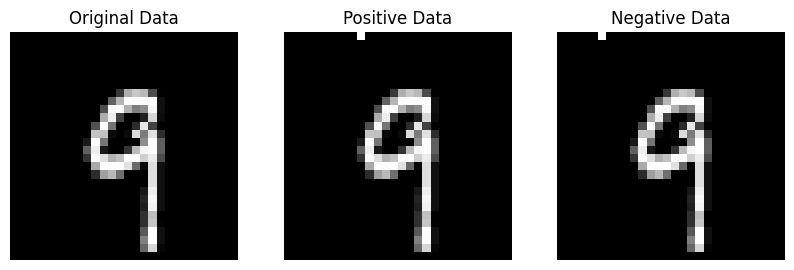

In [54]:
train_loader, test_loader = MNIST_loaders()
x, y = next(iter(train_loader))
x_pos_sample = gen_pos_data(x, y)[0]
x_neg_sample = gen_neg_data(x, y)[0]
reshaped_org = x[0].cpu().reshape(28, 28)
reshaped_pos = x_pos_sample.cpu().reshape(28, 28)
reshaped_neg = x_neg_sample.cpu().reshape(28, 28)

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)
plt.imshow(reshaped_org, cmap="gray")
plt.axis('off')
plt.title("Original Data")

fig.add_subplot(1, 3, 2)
plt.imshow(reshaped_pos, cmap="gray")
plt.axis('off')
plt.title("Positive Data")

fig.add_subplot(1, 3, 3)
plt.imshow(reshaped_neg, cmap="gray")
plt.axis('off')
plt.title("Negative Data")

Now we need to create FF_Net and FF_Layer classes to build the Network and implement the Forward-Forward algorithm.
We implemented a neural network with two hidden layer, first one has 512 neurons and the second one has 256 neurons.
In predict part we generate labeled images with every 10 labels, then we calculate total goodness of layers with this labeled image, in the final step we choose label which maximize total goodness as prediction result.

In [55]:
# Define a Feedforward Neural Network class that inherits from torch.nn.Module
class FF_Net(torch.nn.Module):

    # Constructor method
    def __init__(self):
        super().__init__()

        # Initialize layers list
        self.layers = []

        # Add two fully connected layers to the network architecture
        # with input size 784, output size 512, and 512 to 256, both on GPU
        self.layers.append(FF_Layer(784, 512).cuda())
        self.layers.append(FF_Layer(512, 256).cuda())

    # Prediction method for the network
    def predict(self, x):
        # List to store goodness for each label
        labels_goodness = []

        # Loop through each label (0 to 9)
        for label in range(10):
            # Generate positive data for the current label
            output = gen_pos_data(x, label)
            total_goodness = 0

            # Iterate through layers and calculate goodness
            for layer in self.layers:
                output = layer(output)
                total_goodness += self.compute_goodness(output)

            # Append total goodness for the current label
            labels_goodness.append(total_goodness.unsqueeze(1))

        # Concatenate goodness values for each label
        labels_goodness = torch.cat(labels_goodness, 1)

        # Determine the label with the maximum goodness
        predicted_label = labels_goodness.argmax(1)

        # Return the predicted label
        return predicted_label

    # Training method for the network
    def train(self, x_pos, x_neg):
        # Initialize positive and negative data
        h_pos, h_neg = x_pos, x_neg

        # Iterate through layers for training
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)

    # Compute goodness method
    def compute_goodness(self, model_output):
        # Calculate goodness as the mean of squared values along the second dimension
        goodness = torch.mean(model_output.pow(2), dim=1)
        return goodness




in this part we have two important function, the first one is forward in which we perform forward pass of layer. we used relu as activation function. second function is train, in this function firstly we derived goodness of positive and negative data, then we used a custom loss function as mentioned in question.
**this loss function is suitable for this algorithm because "the aim of the learning is to make the goodness be well above some thereshold value for real data and well below that value for negative data". in the paper probability of positive data is defined as: $$p(positive) = \sigma \big(\sum_j y_j^2 - \theta \big) $$
this loss function is equal to calculate binary cross entropy using this probability function.
in the last part, with using of gradient decent we updated the parameters in a way that minimizing loss function of this layer it self.

In [56]:
class FF_Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.num_epochs = 1500
        self.threshold = 4.0

    def forward(self, x):
        # Normalize input along the second dimension (row-wise) to have unit L2 norm
        x_normalized = x / (x.norm(2, dim=1, keepdim=True) + 1e-6)

        # Perform linear transformation and add bias
        linear_output = torch.mm(x_normalized, self.weight.T) + self.bias.unsqueeze(0)

        # Apply ReLU activation function
        activated_output = self.relu(linear_output)

        return activated_output

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # Compute goodness of positive and negative data
            model_output = self.forward(x_pos)
            g_pos = self.compute_goodness(model_output)
            model_output = self.forward(x_neg)
            g_neg = self.compute_goodness(model_output)

            # Compute Loss function
            loss = self.compute_loss(g_pos, g_neg)

            # optimization step
            self.optimize(loss)

        # Return the forward pass results for positive and negative data
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

    def compute_goodness(self, model_output):
        goodness = torch.mean(model_output.pow(2), dim=1)
        return goodness

    def compute_loss(self, g_pos, g_neg):
        loss = torch.log(1 + torch.exp(torch.cat([self.threshold - g_pos, g_neg - self.threshold]))).mean()
        return loss

    def optimize(self, loss):
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

Now we want to evaluate the algorithm by training the Mnist data set on it. As you can see the results are acceptable.

In [ ]:
# Set a manual seed for reproducibility
torch.manual_seed(23)

# Load MNIST data into train and test loaders
train_loader, test_loader = MNIST_loaders()

# Create an instance of the FF_Net class
net = FF_Net()

# Load a batch of training data and move it to the GPU
x_train, y_train = next(iter(train_loader))
x_train, y_train = x_train.cuda(), y_train.cuda()

# Generate positive and negative data for training
x_pos = gen_pos_data(x_train, y_train)
x_neg = gen_neg_data(x_train, y_train)

# Train the neural network on the generated data
net.train(x_pos, x_neg)

# Evaluate the training accuracy and error
train_accuracy = (torch.tensor(net.predict(x_train)) == y_train).float().mean().item()
print(f'Train accuracy: {train_accuracy}')

train_error = 1.0 - train_accuracy
print(f'Train error: {train_error}')

training layer 0 ...


100%|██████████| 1500/1500 [01:19<00:00, 18.76it/s]


training layer 1 ...


100%|██████████| 1500/1500 [00:31<00:00, 48.22it/s]


Train accuracy: 0.9328199625015259
Train error: 0.06718003749847412


<ipython-input-13-4ca4d7af3f27>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_accuracy = (torch.tensor(net.predict(x_train)) == y_train).float().mean().item()


In [ ]:
# Load a batch of test data and move it to the GPU
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.cuda(), y_test.cuda()

# Evaluate the test accuracy and error
test_accuracy = net.predict(x_test).eq(y_test).float().mean().item()
print(f'Test accuracy: {test_accuracy}')

test_error = 1.0 - test_accuracy
print(f'Test error: {test_error}')

Test accuracy: 0.9319999814033508
Test error: 0.06800001859664917


**Unsupervised method:**

In [57]:
import torch.nn.functional as F

def gen_mask(shape, itr = 10):

    # Create filters as mentioned in paper
    filter_1 = torch.tensor(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)), dtype=torch.float32)
    filter_2 = filter_1.T

    # Create a random binary image as a PyTorch tensor
    image = torch.randint(0, 2, size=shape, dtype=torch.float32)

    # Blur the image with the specified filter
    for i in range(itr):
        image = torch.abs(F.conv2d(image.unsqueeze(0).unsqueeze(0), filter_1.unsqueeze(0).unsqueeze(0), padding=1)[0][0] / filter_1.sum())
        image = torch.abs(F.conv2d(image.unsqueeze(0).unsqueeze(0), filter_2.unsqueeze(0).unsqueeze(0), padding=1)[0][0] / filter_2.sum())

    # Binarize the blurred image, i.e., threshold it at 0.5
    mask = torch.round(image).byte()

    return mask


In [70]:
def gen_neg_img(image_1, image_2):

    # Create a binary mask
    mask = gen_mask(image_1.shape)

    # Element-wise multiplication with the mask
    masked_image_1 = image_1 * mask
    masked_image_2 = image_2 * (1 - mask)

    # Element-wise addition of masked images
    result_image = masked_image_1 + masked_image_2

    return result_image

In this part we want to show one example of how negative data are constructed.

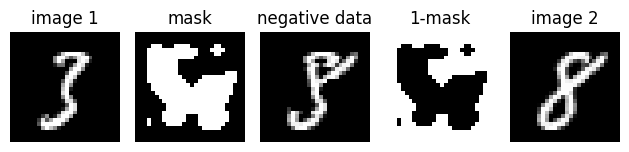

In [72]:
# Load the MNIST dataset
train_loader, test_loader = MNIST_loaders()
x, y = next(iter(train_loader))

# Reshape data from flatten to 28*28
images = torch.reshape(x, (x.shape[0],28,28))

# Get two random images from training data
image_1 = images[np.random.randint(len(images))]
image_2 = images[np.random.randint(len(images))]

# Generate a random mask
mask = gen_mask((28, 28))

# Generating a negative input using mask and two random images
image = gen_neg_img(image_1, image_2)

# Show the results
images = [image_1, mask, image, 1-mask, image_2]
names = ["image 1", "mask", "negative data", "1-mask", "image 2"]

fig, axes = plt.subplots(1, 5)

for ax, image, name in zip(axes, images, names):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(name)

plt.tight_layout()
plt.show()


Now in this block we generated all negative data

In [64]:
def gen_neg_data_unsupervised(images):
    neg_images = []

    # Get the batch size
    batch_size = images.shape[0]

    # Generate negative images by combining random pairs
    for _ in range(batch_size):
        idx1, idx2 = torch.randint(0, batch_size, size=(2,))
        neg_images.append(gen_neg_img(images[idx1].squeeze(), images[idx2].squeeze()))

    # Stack the negative images into a single tensor and add a channel dimension
    neg_images = torch.unsqueeze(torch.stack(neg_images), dim=1)

    return neg_images

In this block we define a new class to make the structure of out neural network to train and predict the data.

In [110]:
# Define a Feedforward Neural Network class that inherits from torch.nn.Module
class FF_Net_Unsupervised(torch.nn.Module):

    # Constructor method
    def __init__(self):
        super().__init__()

        # Initialize layers list
        self.layers = []

        # Add two fully connected layers to the network architecture
        # with input size 784, output size 512, and 512 to 256, both on GPU
        self.layers.append(FF_Layer(784, 512).cuda())
        self.layers.append(FF_Layer(512, 256).cuda())

    # Prediction method for the network
    def predict(self, x):
        # List to store goodness for each label
        labels_goodness = []

        # Loop through each label (0 to 9)
        for label in range(10):
            # Generate positive data for the current label
            output = gen_pos_data(x, label)
            total_goodness = 0

            # Iterate through layers and calculate goodness
            for layer in self.layers:
                output = layer(output)


        # Return the predicted label
        return output

    # Training method for the network
    def train(self, x_pos, x_neg):
        # Initialize positive and negative data
        h_pos, h_neg = x_pos, x_neg

        # Iterate through layers for training
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)

    # Compute goodness method
    def compute_goodness(self, model_output):
        # Calculate goodness as the mean of squared values along the second dimension
        goodness = torch.mean(model_output.pow(2), dim=1)
        return goodness

In [80]:
# Set a manual seed for reproducibility
torch.manual_seed(23)

# Load MNIST data into train and test loaders
train_loader, test_loader = MNIST_loaders()

# Create an instance of the FF_Net class
net = FF_Net_Unsupervised()

# Load a batch of training data and move it to the GPU
x_train, y_train = next(iter(train_loader))

# Reshape data from flatten to 28*28
x_train = torch.reshape(x_train, (x_train.shape[0],28,28))

# Generate positive and negative data for training
x_pos = x_train
x_neg = gen_neg_data_unsupervised(x_train)

# Flatten the images
x_train = torch.reshape(x_train, (x_train.shape[0],784))
x_pos = torch.reshape(x_pos, (x_pos.shape[0],784))
x_neg = torch.reshape(x_neg, (x_neg.shape[0],784))


In [81]:
# Train the network
x_pos = x_pos.cuda()
x_neg = x_neg.cuda()

net.train(x_pos, x_neg)

x_train = x_train.cuda()

# output of two hidden layer after training
output_FF = net.predict(x_train)

training layer 0 ...


100%|██████████| 1500/1500 [01:33<00:00, 15.97it/s]


training layer 1 ...


100%|██████████| 1500/1500 [00:34<00:00, 43.69it/s]


The output of our FF network for each of the traing data is a feature vector with size of 256, we hope this features are useful to classify data using a linear classifier in next part .now we need define a linear classifier to clasify the data.

In [107]:
import torch.optim as optim

# Move data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
output_FF = output_FF.to(device)
y_train = y_train.to(device)

# Define a linear classifier
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Create an instance of the linear classifier
input_size = 256
num_classes = 10
classifier = LinearClassifier(input_size, num_classes)
classifier = classifier.to(device)  # Move model to GPU if available

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.01)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = classifier(output_FF)

    # Compute the loss
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




Epoch [100/1000], Loss: 2.2793
Epoch [200/1000], Loss: 2.2793
Epoch [300/1000], Loss: 2.2793
Epoch [400/1000], Loss: 2.2793
Epoch [500/1000], Loss: 2.2793
Epoch [600/1000], Loss: 2.2793
Epoch [700/1000], Loss: 2.2793
Epoch [800/1000], Loss: 2.2793
Epoch [900/1000], Loss: 2.2793
Epoch [1000/1000], Loss: 2.2793


Now we want to calculate the test accuracy.

In [111]:
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.cuda(), y_test.cuda()

output_FF = net.predict(x_test)

outputs = classifier(output_FF)
_, predicted = torch.max(outputs, 1)
accuracy = (predicted == y_test.to(device)).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

Test Accuracy: 0.0847
